### Time Signal을 input으로 넣고 Time+PSD를 Loss로 설정
#### X에 맞춰서 y를 scaling (X, y 각각 scaling 했을 때 학습이 잘 안됨)

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../../tool_code/python_tool_code_function/') # "~~/tool_code/plot/" (상대 경로)

from DataPlot import Data_Load_Plot, Result_Plot, Loss_Plot
from Scaling import time_scaling, time_inv_scaling

sys.path.append('../../../../tool_code/python_tool_code/frequency_dataset_generation/')
from FFT_func import FFT

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


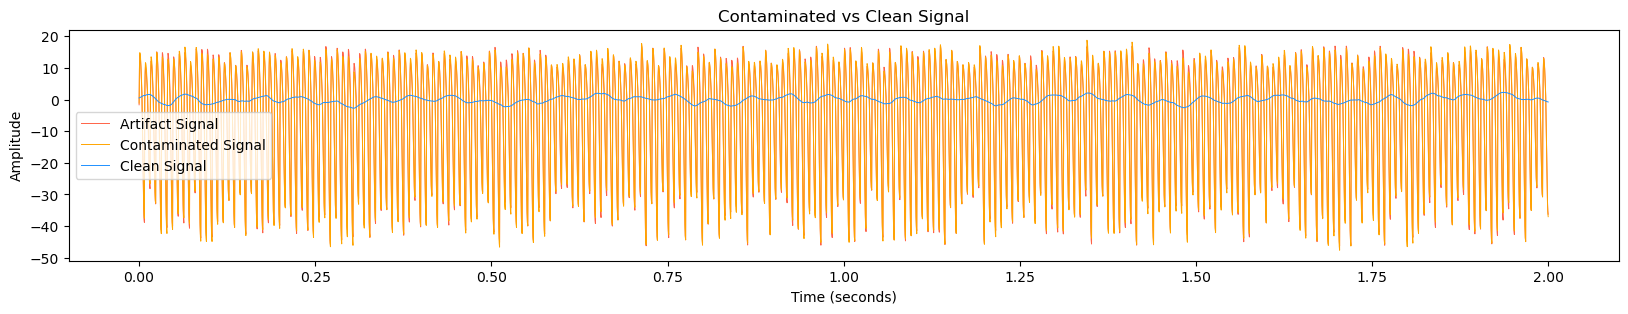

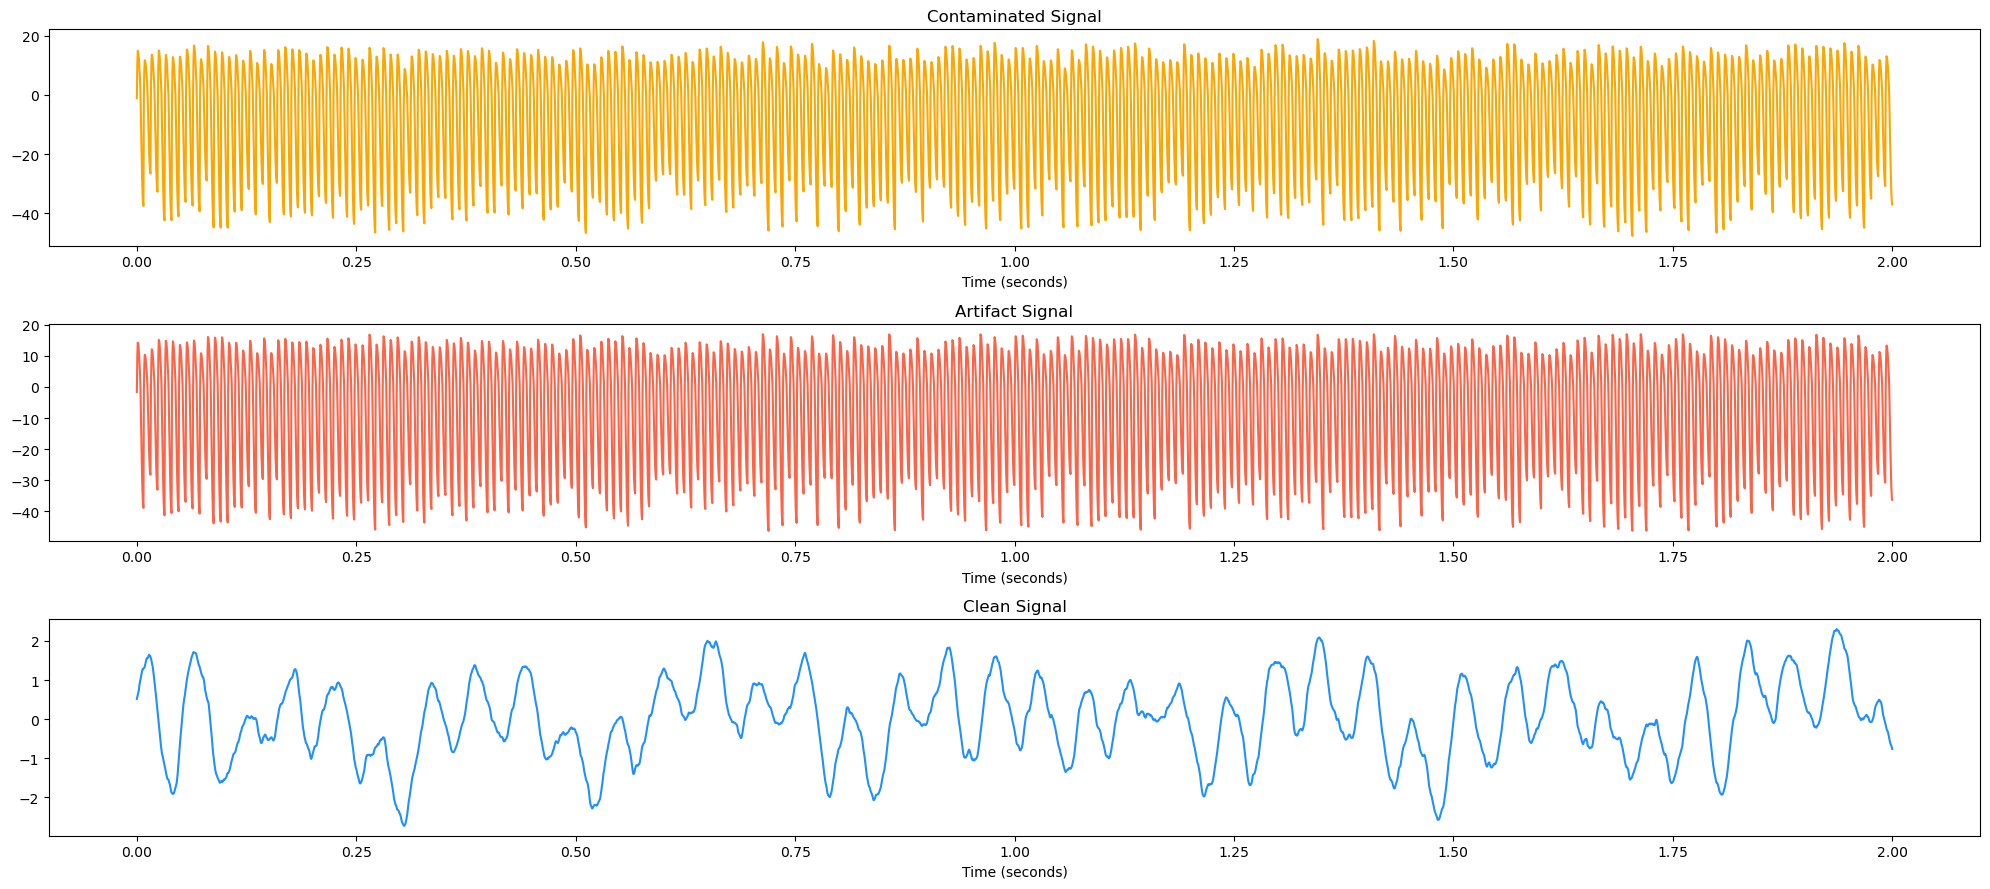

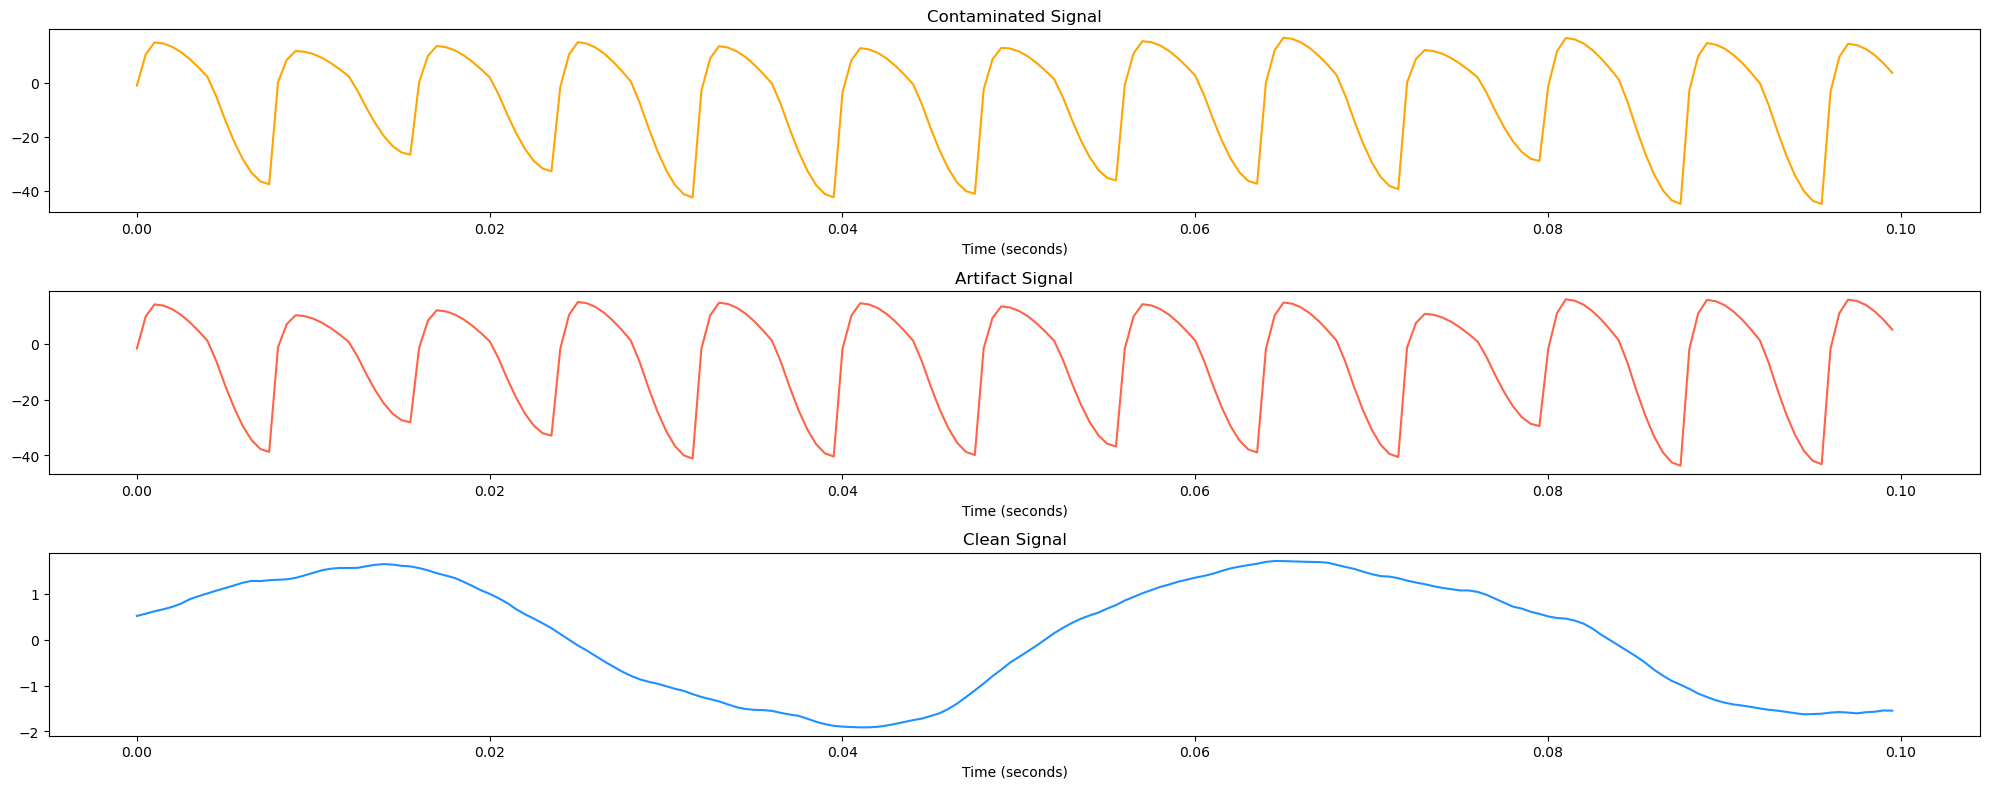

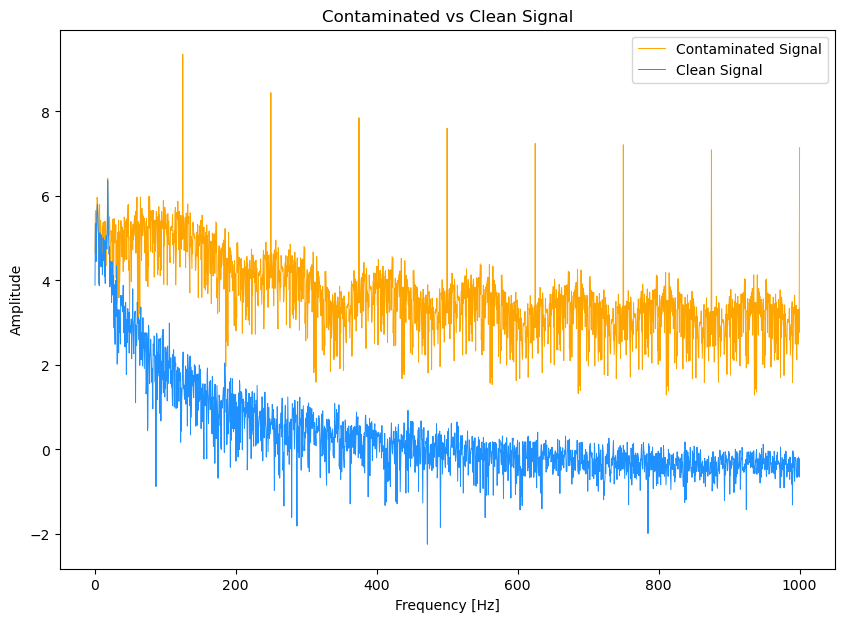

In [2]:
# 데이터 load & plot
datapath='../../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("<Original>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T, y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

# 차원 추가 (LSTM은 세번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # Batch x length x 1
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1) # Batch x length x 1
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)

print("<Unsqueezed>")
print("-----------------------------")
print(f"X_train shape: {X_train.shape}\ny_train shape: {y_train.shape}") # x : B x T x 1 , y : B x T
print("-----------------------------")
print(f"X_test shape: {X_test.shape}\ny_test shape: {y_test.shape}")
print("-----------------------------")

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

<Original>
-----------------------------
X_train shape: (800, 4000)
y_train shape: (800, 4000)
-----------------------------
X_test shape: (200, 4000)
y_test shape: (200, 4000)
-----------------------------
<Unsqueezed>
-----------------------------
X_train shape: (800, 4000, 1)
y_train shape: (800, 4000, 1)
-----------------------------
X_test shape: (200, 4000, 1)
y_test shape: (200, 4000, 1)
-----------------------------


In [5]:
# 모델 정의
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=64)
        self.fc4 = nn.Linear(in_features=64, out_features=1)
        self.drop = nn.Dropout(0.25)
        self.gelu = nn.GELU()

    def forward(self, input_data): # x : B x T x 1
        x = self.gelu(self.fc1(input_data)) # x : B x T x 256
        x = self.drop(x)
        x = self.gelu(self.fc2(x)) # x : B x T x 128
        x = self.drop(x)
        x = self.gelu(self.fc3(x)) # x : B x T x 64
        x = self.drop(x)
        x = self.fc4(x) # x : B x T x 1 -> x : B x T
        return x

model = MLP().to(device)
print(model)

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [6]:
# 손실 함수 정의
class LossFunction(nn.Module):
    def __init__(self, alpha=0.5):
        super(LossFunction, self).__init__()
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()

    def forward(self, y_pred, y, y_pred_welch, y_welch):
        signal_loss = self.mse_loss(y_pred, y)
        welch_loss = self.mse_loss(y_pred_welch, y_welch)
        return self.alpha * signal_loss + (1 - self.alpha) * welch_loss

In [7]:
# 모델 인스턴스 생성
model = MLP().to(device)
print(model)
    
# 손실 함수와 옵티마이저 정의
alpha = 0.5
criterion = LossFunction(alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse = nn.MSELoss()
fs = 2000

MLP(
  (fc1): Linear(in_features=1, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (gelu): GELU(approximate='none')
)


In [8]:
# 모델 훈련
num_epochs = 200

loss_list = []

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0]
        y = batch[1]
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        batch_size, seq_len = y.squeeze().shape
        y1 = y.view(batch_size, -1)
        y_pred1 = y_pred.view(batch_size, -1)

        # 텐서를 CPU로 옮기고 NumPy 배열로 변환
        y_cpu = y1.detach().cpu().numpy()
        y_pred_cpu = y_pred1.detach().cpu().numpy()

        
        # Welch 스펙트럼 계산
        y_welch_list = [welch(y_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]
        y_pred_welch_list = [welch(y_pred_cpu[i], fs, nperseg=256, noverlap=128, window='hann')[1] for i in range(batch_size)]

        # Welch 결과의 길이를 모델의 입력 형태와 맞추기
        # 여기에 적절한 패딩이나 크기 조정이 필요할 수 있습니다
        y_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_welch_list])
        y_pred_welch = np.array([np.pad(arr, (0, max(0, seq_len - len(arr))), mode='constant')[:seq_len] for arr in y_pred_welch_list])

        # NumPy 배열을 다시 텐서로 변환하여 손실 함수에 전달
        y_welch = torch.tensor(y_welch, dtype=torch.float32).to(device)
        y_pred_welch = torch.tensor(y_pred_welch, dtype=torch.float32).to(device)

        loss = criterion(y_pred, y, y_pred_welch, y_welch)
        y_val_mse = mse(y_pred, y)*alpha
        y_welch_mse = mse(y_pred_welch, y_welch)*(1-alpha)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_list.append(loss.item())
    if (epoch+1)%1 == 0:
       print(f'Epoch [{epoch+1}/{num_epochs}] | Loss: {loss.item():6f} | y_val_mse: {y_val_mse:6f} | y_welch_mse: {y_welch_mse}')

Epoch [1/200] | Loss: 0.002955 | y_val_mse: 0.002955 | y_welch_mse: 3.4527337586243156e-12
Epoch [2/200] | Loss: 0.002288 | y_val_mse: 0.002288 | y_welch_mse: 3.2699251292789278e-12
Epoch [3/200] | Loss: 0.002141 | y_val_mse: 0.002141 | y_welch_mse: 3.314684247565647e-12
Epoch [4/200] | Loss: 0.002072 | y_val_mse: 0.002072 | y_welch_mse: 3.3393474617449126e-12
Epoch [5/200] | Loss: 0.002013 | y_val_mse: 0.002013 | y_welch_mse: 3.2922763907455854e-12
Epoch [6/200] | Loss: 0.001959 | y_val_mse: 0.001959 | y_welch_mse: 3.320696582292948e-12
Epoch [7/200] | Loss: 0.001923 | y_val_mse: 0.001923 | y_welch_mse: 3.4107621241230568e-12
Epoch [8/200] | Loss: 0.001886 | y_val_mse: 0.001886 | y_welch_mse: 3.4240253861395065e-12
Epoch [9/200] | Loss: 0.001851 | y_val_mse: 0.001851 | y_welch_mse: 3.444803687094322e-12
Epoch [10/200] | Loss: 0.001825 | y_val_mse: 0.001825 | y_welch_mse: 3.3996757232285235e-12
Epoch [11/200] | Loss: 0.001797 | y_val_mse: 0.001797 | y_welch_mse: 3.2806168805826763e-12


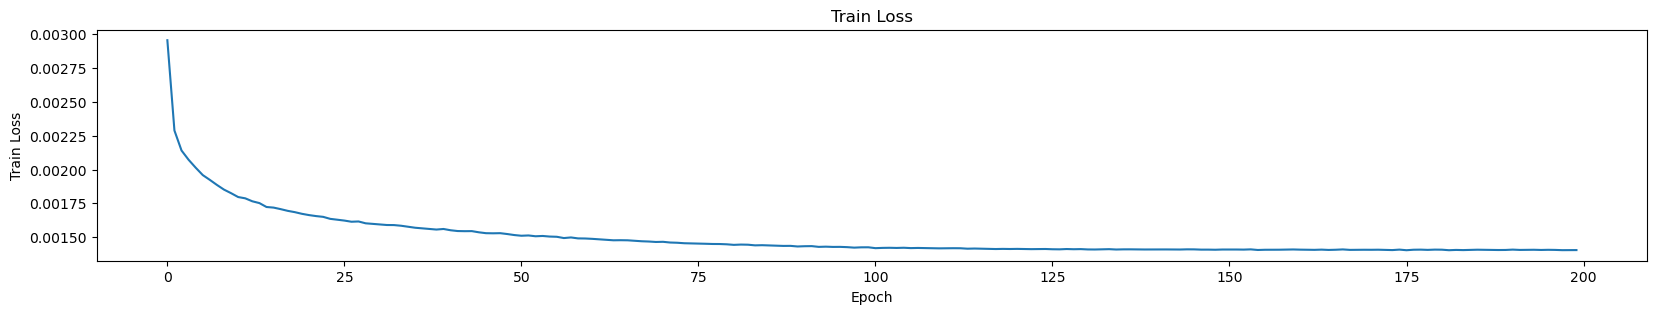

Minimal Train Loss: 0.0014035269850865006 [175]



In [9]:
# Train Loss Plot
Train_Loss_Plot(loss_list)

In [10]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])
SACed_spectro = torch.tensor([])
Clean_spectro = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)

        y_pred = model(x) # y_pred : B x T

        # # 각 배치 항목에 대해 FFT를 수행하고 스펙트럼 계산
        # batch_size, seq_len = y.shape
        # y = y.view(batch_size, -1).cpu()
        # y_pred = y_pred.view(batch_size, -1).cpu()
        # print("y.shape:", y.shape)

        # _, y_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # _, y_pred_welch = welch(y.numpy(), fs, nperseg=256, noverlap=128, window='hann')
        # print("y_welch.shape:", y_welch.shape)

        # loss = criterion(y_pred, y, y_pred_welch, y_welch)
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.squeeze().cpu()), 0)
        Clean = torch.cat((Clean, y.squeeze().cpu()), 0)
        # SACed_spectro = torch.cat((SACed_spectro, y_pred_welch.cpu()), 0)
        # Clean_spectro = torch.cat((Clean_spectro, y_welch.cpu()), 0)

# val_loss = criterion(SACed, Clean, SACed_spectro, Clean_spectro)
# print(f'Test Loss: {val_loss.item()}')           

<Time Domain Error>
Mean Absolute Error: 0.8039532296635054
Mean Squared Error: 0.9714569797649838


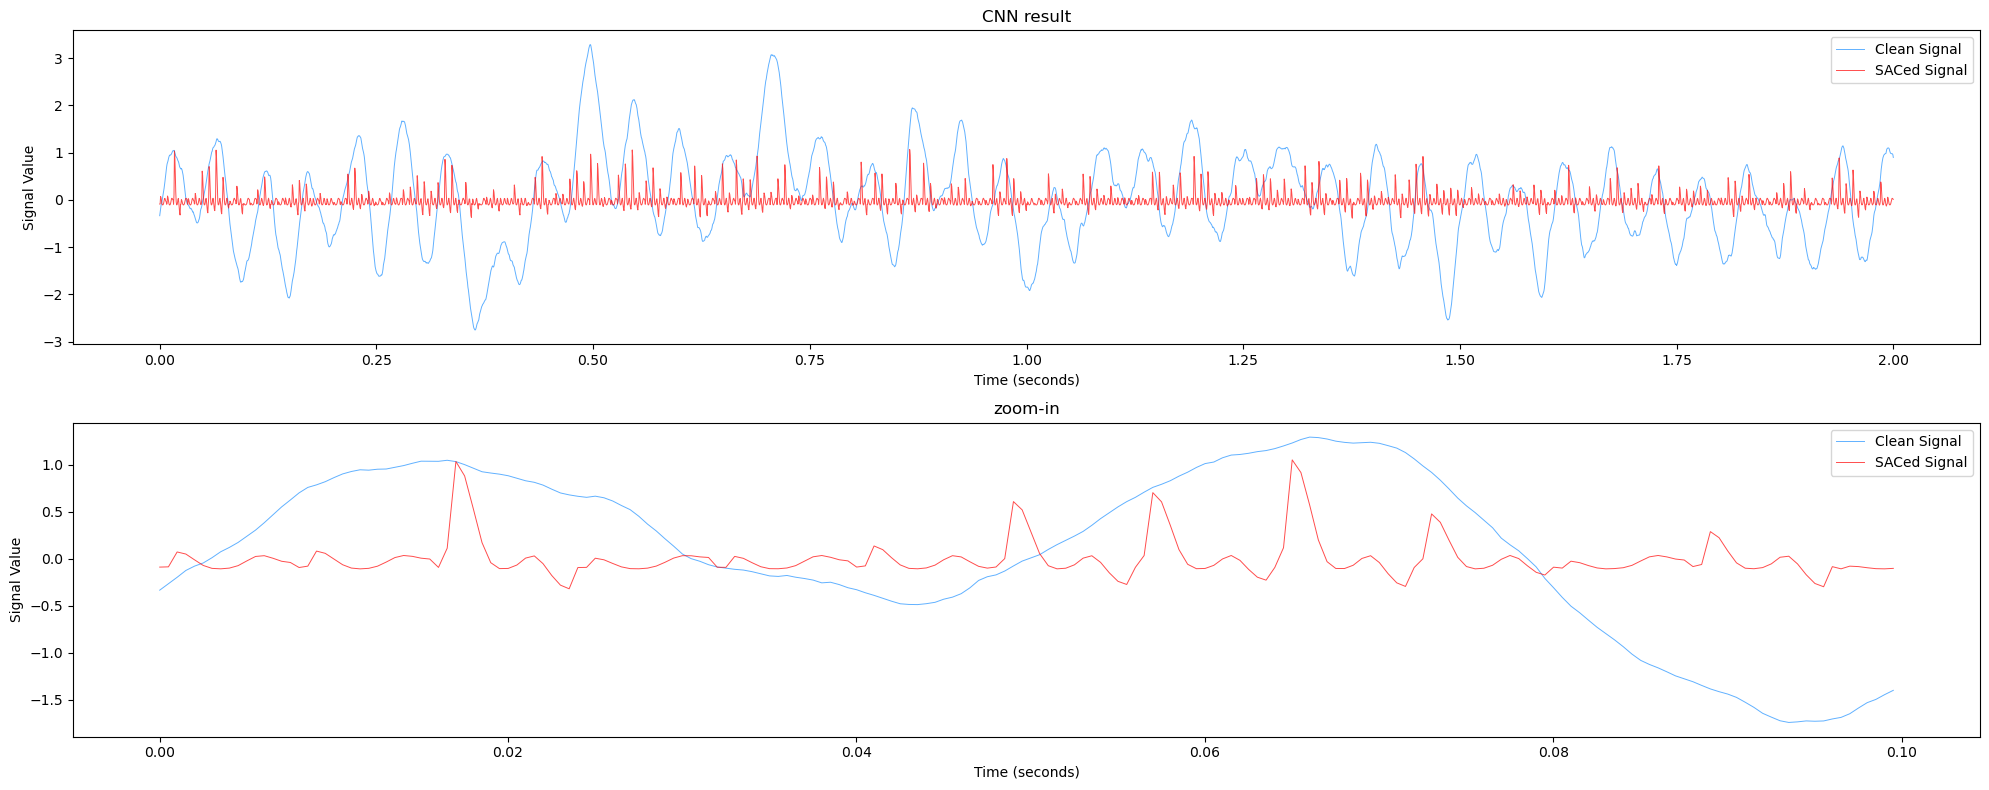

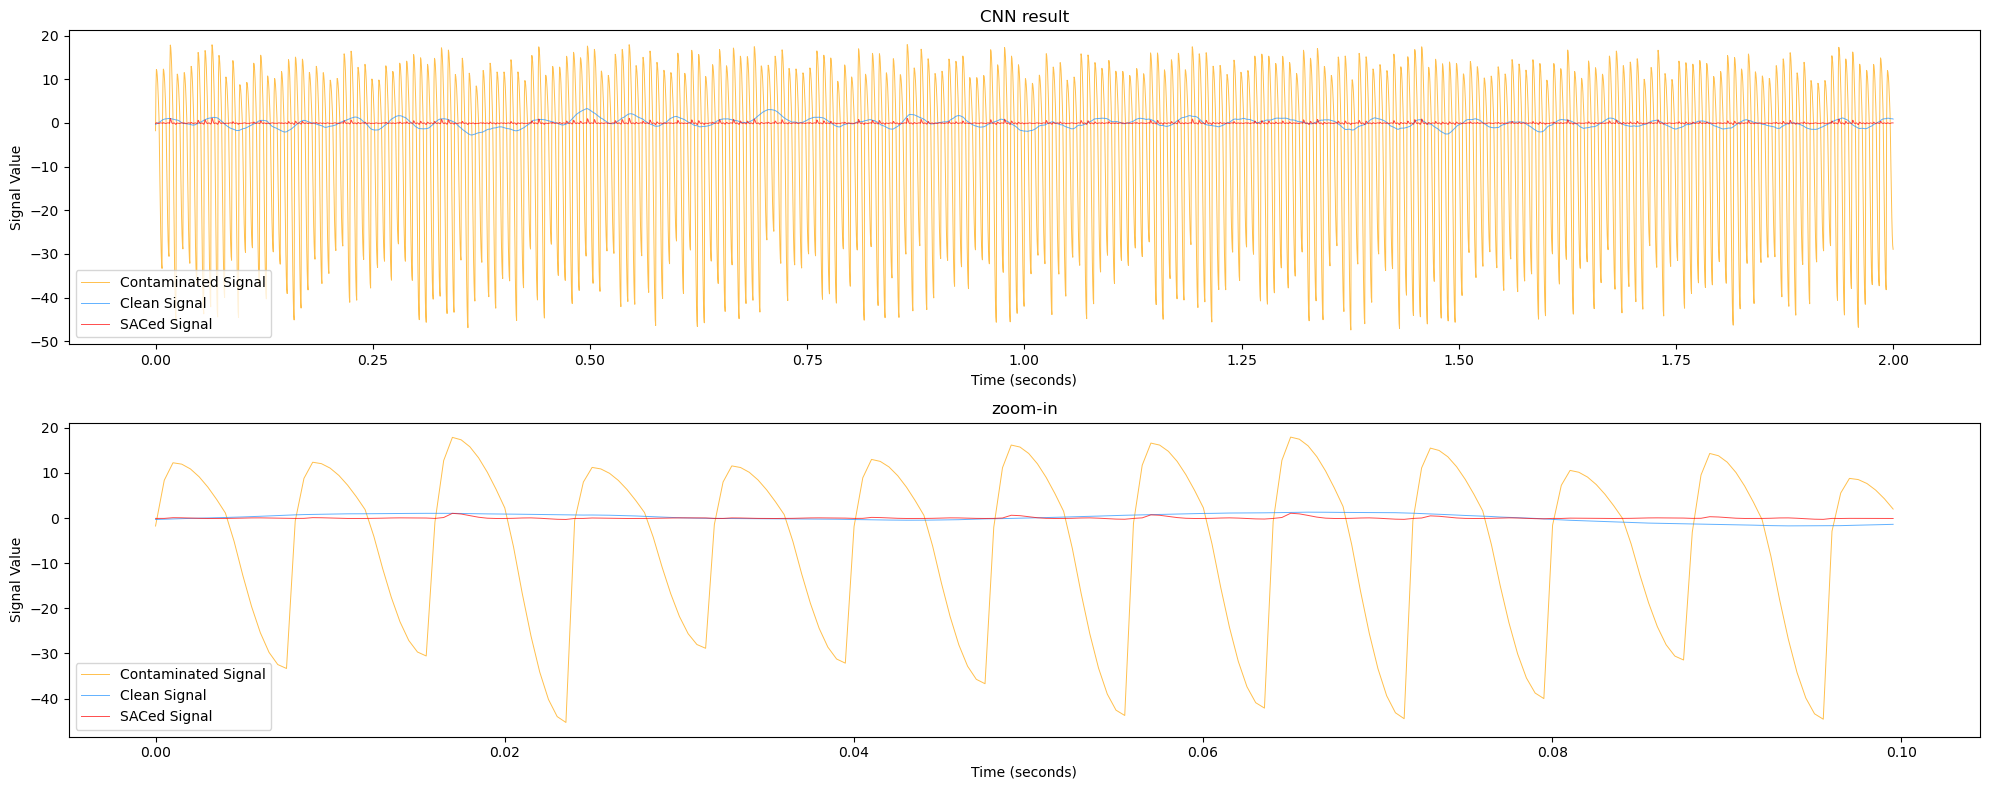

<Frequency Domain Error>
Mean Absolute Error: 1.0612744980782802
Mean Squared Error: 1.8157891957190497


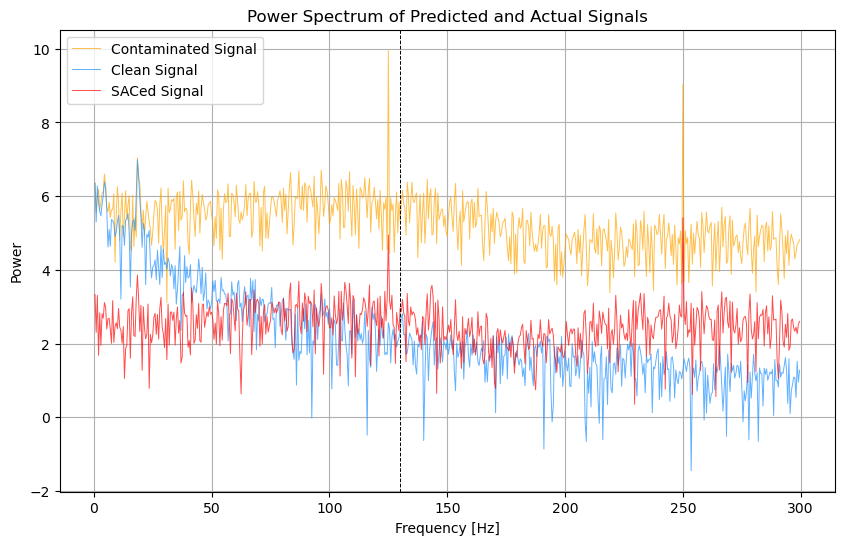

In [11]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

# 결과 Plot
Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

<Time Domain Error>
Mean Absolute Error: 0.04320520907640457
Mean Squared Error: 0.0028056539595127106


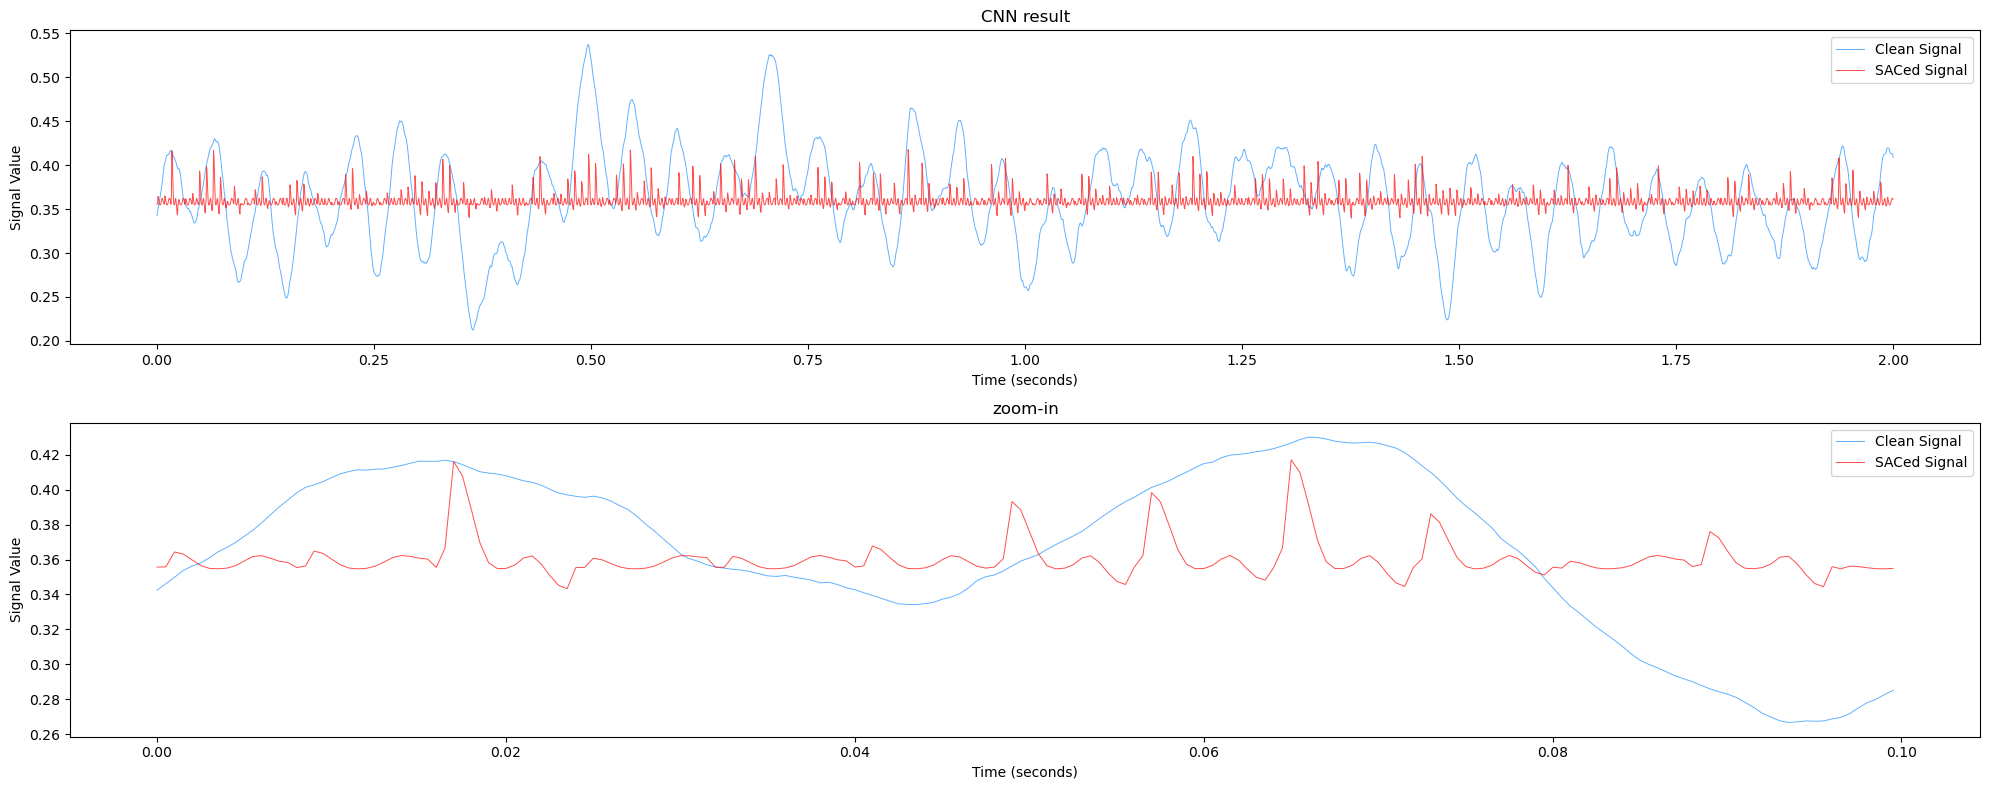

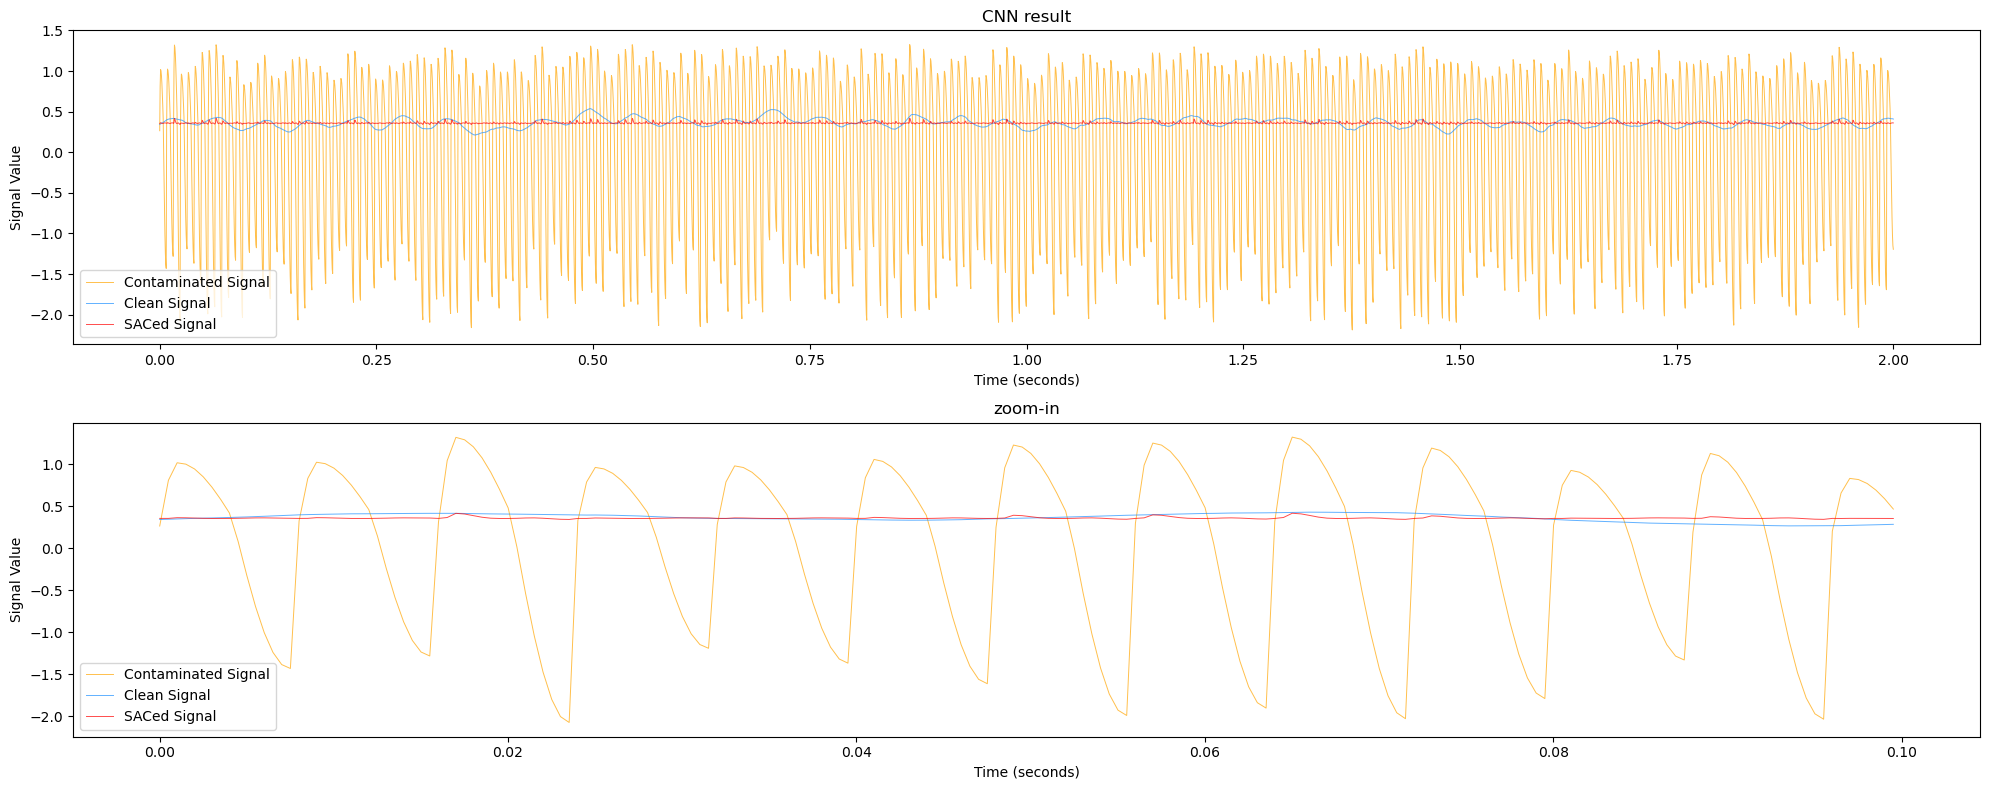

<Frequency Domain Error>
Mean Absolute Error: 1.0543493841315712
Mean Squared Error: 1.7193694479161963


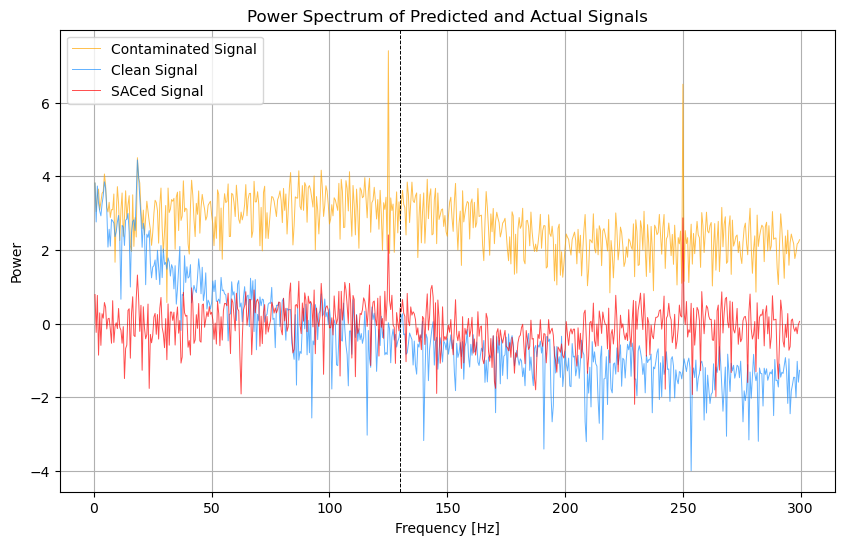

In [12]:
# 원래 scale
Result_Plot(Contaminated, SACed, Clean)